In [1]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
VERSION = 4
RANDOM_SEED = 7
import librosa
import librosa.display
from librosa.core import load
import parselmouth
from feature_extraction_utils import *
import pickle

## compile external data 

In [2]:
def get_duration(file_path):
    try:
        y, sr = librosa.load(file_path)
        duration_seconds = librosa.get_duration(y=y, sr=sr)
        yt, index = librosa.effects.trim(y,top_db=20)
        duration_seconds_trim = librosa.get_duration(y=yt, sr=sr)
        return round(duration_seconds,2), round(duration_seconds_trim,2)
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return 0

dataset_name = "unknown"
dataset_folder = f"./Final_test_data/test_set/files"
# Dictionary to map emotional categories to sentiment values
sentiment_mapping = {
    "Anger": -1,
    "Angry": -1,
    "Disgust": -1,
    "Fear": -1,
    "Fearful": -1,
    "Happy": 1,
    "Happiness": 1,
    "Surprised": 1,
    "Surprise": 1,
    "Neutral": 0,
    "Neutrality": 0,
    "Calm": 0,
    "Calmness": 0,
    "Sad": -1,
    "Sadness": -1
}

# Function to map emotional category to sentiment value
def map_to_sentiment(emotional_category):
    return sentiment_mapping.get(emotional_category, 0)

# Dictionary to map emotional categories based on file names
emotional_mapping_test= {
    "euphoric": "Happiness",
    "surprised": "Surprise",
    "joyfully": "Happiness",
    "sad": "Sadness"
}
# Function to extract emotional category from file name
def get_emotional_category_test(file_name):
    for key, value in emotional_mapping_test.items():
        if key in file_name:
            return value
    return "Unknown"


In [3]:
master_info = pd.read_csv('./Final_test_data/test_set/speech_emotions.csv')
master_info = master_info.drop(columns=['Unnamed: 0'])
master_info['speaker_id'] = master_info['set_id'].apply(lambda x: x[-4:])
master_info['gender'] = master_info['gender'].map({'FEMALE': 'F', 'MALE': 'M'})
master_info.head()

,set_id,text,gender,age,country,speaker_id
0,00026029e0--64991b6eef1fe70609d48edc,The delicious aroma of freshly baked bread fil...,M,29,ZA,8edc
1,00026029e0--64991b72e0daf97163c09c66,I enjoy taking long walks in the peaceful coun...,F,42,NG,9c66
2,00026029e0--64991b7fd94c0d5726dec353,The suspenseful novel kept me on the edge of m...,F,29,VN,c353
3,00026029e0--64991b907f82d9763944eba2,They celebrated their anniversary with a roman...,F,20,PK,eba2
4,00026029e0--64991bf2ffab6240f9f2418b,The diligent student earned top marks for her ...,M,30,PK,418b


In [5]:
file_info_list = []

for _, dirs, _ in os.walk(dataset_folder):
    for sub_dir in dirs:
        for root, _, files in os.walk(os.path.join(dataset_folder,sub_dir)):
            for file in files:
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    emotional_category = get_emotional_category_test(file)
                    speaker_id = root[-4:]
                    sentiment_value = map_to_sentiment(emotional_category)
                    duration, duration_trimmed = get_duration(file_path)
                    row = master_info[master_info.speaker_id==speaker_id].iloc[0].to_dict()
                    file_info_list.append({
                        **row,
                        "dataset_name": dataset_name,
                        "file_path": file_path,
                        "sentiment_value": sentiment_value,
                        "emotional_category": emotional_category,
                        "duration": duration,
                        "duration_trimmed": duration_trimmed
                    })

df = pd.DataFrame(file_info_list)
df.to_csv(f"./Final_test_data/test_set/compiled.csv", index=False)
df.tail(10)

,set_id,text,gender,age,country,speaker_id,dataset_name,file_path,sentiment_value,emotional_category,duration,duration_trimmed
58,00026029e0--6499226eef1fe70609d66276,The athlete's dedication and hard work led to ...,M,20,PK,6276,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Surprise,7.10,6.97
59,00026029e0--6499226eef1fe70609d66276,The athlete's dedication and hard work led to ...,M,20,PK,6276,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Happiness,6.06,5.97
60,00026029e0--64991bfc63d8b20f56d0e1fb,The rhythmic beat of the drums echoed through ...,M,18,IN,e1fb,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Happiness,11.88,4.90
61,00026029e0--64991bfc63d8b20f56d0e1fb,The rhythmic beat of the drums echoed through ...,M,18,IN,e1fb,unknown,./Final_test_data/test_set/files/00026029e0--6...,-1,Sadness,9.00,6.08
62,00026029e0--64991bfc63d8b20f56d0e1fb,The rhythmic beat of the drums echoed through ...,M,18,IN,e1fb,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Surprise,6.80,4.83
63,00026029e0--64991bfc63d8b20f56d0e1fb,The rhythmic beat of the drums echoed through ...,M,18,IN,e1fb,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Happiness,5.42,3.39
64,00026029e0--64991c0dd94c0d5726df032a,The curious child eagerly explored the vast mu...,M,21,MX,032a,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Happiness,6.46,3.16
65,00026029e0--64991c0dd94c0d5726df032a,The curious child eagerly explored the vast mu...,M,21,MX,032a,unknown,./Final_test_data/test_set/files/00026029e0--6...,-1,Sadness,6.40,3.72
66,00026029e0--64991c0dd94c0d5726df032a,The curious child eagerly explored the vast mu...,M,21,MX,032a,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Surprise,5.48,3.02
67,00026029e0--64991c0dd94c0d5726df032a,The curious child eagerly explored the vast mu...,M,21,MX,032a,unknown,./Final_test_data/test_set/files/00026029e0--6...,1,Happiness,5.28,3.13


## feature extraction for extra test data from compiled csv file

In [12]:
filename_list_ext_test = df.file_path.tolist()
features_ext_test =  []
bookmark=0
sample_rate_set = 16000
start = time.time()
for _,filename in enumerate(filename_list_ext_test):
    features = calc_feature_all(filename)
    features_ext_test.append(features)

pd.DataFrame(features_ext_test)

,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,Formant_f1_median,Formant_f2_median,Formant_f3_median,Formant_f4_median,Formant_formant_dispersion,Formant_average_formant,Formant_mff,Formant_fitch_vtl,Formant_delta_f,Formant_vtl_delta_f
0,-257.207916,104.303833,9.537237,41.351448,-17.766405,21.409136,-2.641380,9.760408,-20.034187,2.759110,...,495.177274,2183.820157,3165.104891,4279.591771,1261.471499,2530.923523,1956.329512,14.456345,1257.840586,13.912733
1,-282.933258,106.684090,22.151114,40.232285,-20.552134,18.158396,-7.827309,9.109068,-20.661907,-0.947792,...,402.892879,2194.929128,3229.344339,4476.843248,1357.983456,2576.002398,1890.924044,15.226618,1296.959636,13.493095
2,-266.142670,93.551826,24.847651,41.229050,-8.106157,17.447182,3.349376,14.733667,-11.937532,-0.516230,...,340.735254,2285.285217,3141.017500,4261.564067,1306.942938,2507.150510,1796.797831,16.366889,1255.538735,13.938240
3,-275.048218,103.198143,20.871792,38.959923,-19.145058,20.827671,-0.962595,8.854782,-12.720783,-2.492331,...,431.309266,2289.776133,3367.869479,4523.579066,1364.089934,2653.133486,1969.494682,14.570410,1328.691393,13.170854
4,-423.896301,60.063931,1.941338,0.018360,-12.178156,-9.023487,-24.965996,5.475420,-31.865870,2.554506,...,488.272183,1592.880808,2486.106672,4117.608014,1209.778610,2171.216919,1679.780385,16.718212,1107.635811,15.799417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-291.452332,89.417831,-6.768806,19.501030,-15.247986,21.236082,-32.721737,1.226377,-7.719341,7.255892,...,530.960697,1528.791738,2828.590102,3966.549214,1145.196172,2213.722938,1737.194284,16.139672,1119.669784,15.629608
64,-418.386353,108.970093,4.155330,5.186665,-14.242478,-4.189284,-10.570671,-7.603477,-15.140280,10.530252,...,479.500673,1206.315898,2583.320804,3642.093264,1054.197530,1977.807660,1527.372332,18.440359,1012.135839,17.290169
65,-436.096008,117.699226,8.287527,8.971478,-17.320686,-2.615419,-17.608034,-7.026821,-16.139797,9.050535,...,477.793235,1285.865184,2552.167148,3957.419222,1159.875329,2068.311197,1578.298529,17.836796,1066.622835,16.406924
66,-401.850311,92.777710,9.685896,13.603906,-15.133779,3.195500,-10.330775,-2.964715,-14.329841,13.279070,...,470.256806,1339.626975,2568.808721,3472.456815,1000.733337,1962.787329,1539.649618,18.217978,991.437596,17.651136


In [15]:
# join feature with labels
df_joint_ext_test = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_ext_test)], axis=1)
df_joint_ext_test = df_joint_ext_test.dropna(how='any')
df_joint_ext_test.to_csv(f'./features/cache_features_ext_test.csv',index=False)
print("shape after drop Nan rows and constant feature: ", df_joint_ext_test.shape)

shape after drop Nan rows and constant feature:  (68, 1554)


## Load data

In [16]:
df_joint_train_aug  = pd.read_csv(f'./features/cache_train_V4_augmented.csv')
feature_column_names = [i for i in df_joint_train_aug.columns \
                        if i not in ['file_path','renamed_file_path','split','sentiment_value','emotional_category']]
df_joint_test = pd.read_csv(f'./features/cache_features_ext_test.csv')

# print("shape of train set: ", df_joint_train.shape)
print("shape of test  set: ", df_joint_test.shape)
def generate_selected_features_by_type(feature_column_names,input,stats,number=1):
    selected_result = []
    for name in feature_column_names:
        if input+"_"+stats in name:
            selected_result.append(name)
    if number < len(selected_result):
        selected_result = selected_result[:number]
    return selected_result

# example to take mfcc 20 mean & std; mel32; zcr all 5 stats features
feature_MFCC20_mean  = generate_selected_features_by_type(feature_column_names,"mfcc","mean",20)
feature_MFCC20_std   = generate_selected_features_by_type(feature_column_names,"mfcc","std",20)
feature_mel32_median = generate_selected_features_by_type(feature_column_names,"mel32","median",32)
feature_mel32_std    = generate_selected_features_by_type(feature_column_names,"mel32","std",32)
feature_zcr_stats    = generate_selected_features_by_type(feature_column_names,"zcr","",5)
feature_rms_stats    = generate_selected_features_by_type(feature_column_names,"rms","",5)
selected_spect = ['Spectrum_band_energy_difference','Spectrum_band_density_difference','Spectrum_center_of_gravity_spectrum','Spectrum_skewness_spectrum','Spectrum_kurtosis_spectrum', 'Spectrum_stddev_spectrum','Spectrum_band_density', 'Spectrum_band_energy']
selected_formant = ['Formant_f1_mean','Formant_f1_median','Formant_f3_mean','Formant_fitch_vtl','Formant_mff','Formant_formant_dispersion']
selected_pitch = ['Pitch_pitch_slope_without_octave_jumps', 'Pitch_q3_pitch','Pitch_stddev_pitch', 'Pitch_mean_absolute_pitch_slope','Pitch_mean_pitch', 'Pitch_max_pitch', 'Pitch_q1_pitch', 'Pitch_min_pitch']
selected_intensity = ['Intensity_max_intensity', 'Intensity_q3_intensity','Intensity_median_intensity', 'Intensity_mean_intensity', 'Intensity_stddev_intensity','Intensity_relative_max_intensity_time']
selected_HNR = ['HNR_stddev_hnr', 'HNR_mean_hnr','HNR_relative_min_hnr_time','HNR_max_hnr']
selected_prosody = selected_intensity + selected_pitch # + ['Local Jitter','Local Shimmer']
selected_feature_names = feature_MFCC20_mean + feature_MFCC20_std + feature_mel32_median + feature_mel32_std + \
                         feature_rms_stats + selected_intensity + selected_pitch + selected_spect
len(selected_feature_names)
### define the selected feature names same as trained model!!!

# default use augmented training set and balanced test set
X_train = df_joint_train_aug[selected_feature_names]
y_train_s = df_joint_train_aug['sentiment_value']
y_train_e = df_joint_train_aug['emotional_category']

X_test = df_joint_test[selected_feature_names]
y_test_s = df_joint_test['sentiment_value']
y_test_e = df_joint_test['emotional_category']

shape of test  set:  (68, 1554)


### Load Data - test input from wav file

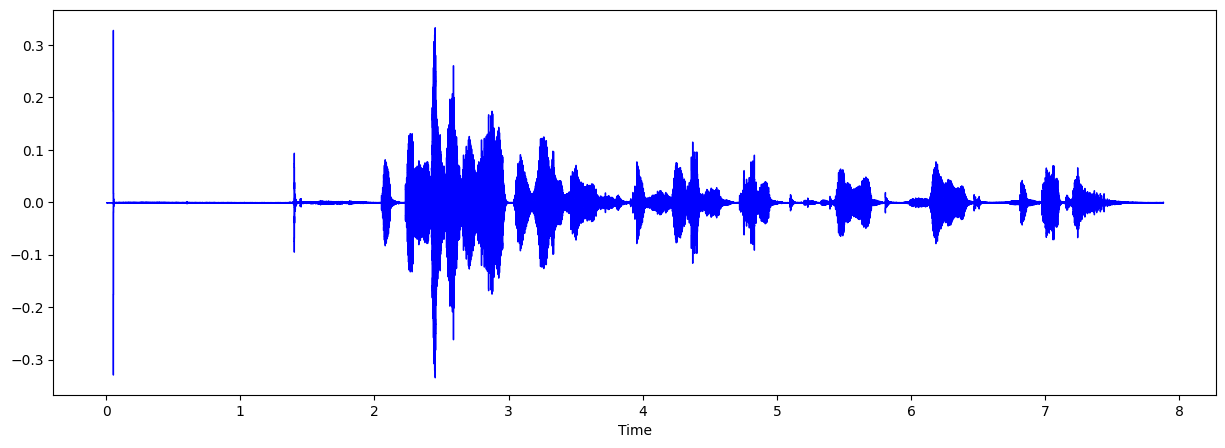

In [25]:
sample_file_path = './Final_test_data/test_set/files/00026029e0--64991b6eef1fe70609d48edc/joyfully.wav'
X, sampling_rate = librosa.load(sample_file_path, res_type='kaiser_fast',duration=10,sr=16000,offset=0)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(X, sr=sampling_rate, color="blue")
# librosa.display.waveshow(stereo[0, :div], sr=sr, ax=axs[2, 0], color="blue")

In [6]:
def get_stats_from_feature(feature_input):
    feature_mean,feature_median = np.mean(feature_input.T, axis=0),np.median(feature_input.T, axis=0)
    feature_std  = np.std(feature_input.T, axis=0)
    feature_p10, feature_p90  = np.percentile(feature_input.T, 10, axis=0), np.percentile(feature_input.T, 90, axis=0)
    return np.concatenate((feature_mean,feature_median,feature_std, feature_p10, feature_p90), axis=0)

In [9]:
def calc_feature_all(sample_file_path):
    sample_rate = 16000
    X, _ = librosa.load(sample_file_path, res_type='kaiser_fast',duration=6,sr=16000,offset=3.0)
    mfccs_60 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=60)
    feature_mfccs_60_stats = get_stats_from_feature(mfccs_60)
    stft = np.abs(librosa.stft(X))
    feature_chroma_stft_stats = get_stats_from_feature(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    feature_mel_32_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=32, fmax=8000))
    feature_mel_64_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=64, fmax=8000))
    feature_mel_128_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=128, fmax=8000))
    
    feature_zcr_stats = get_stats_from_feature(librosa.feature.zero_crossing_rate(y=X))
    feature_rms_stats = get_stats_from_feature(librosa.feature.rms(y=X))
    
    features  = np.concatenate((feature_mfccs_60_stats,
                                    feature_chroma_stft_stats,
                                    feature_mel_32_stats,
                                    feature_mel_64_stats,
                                    feature_mel_128_stats,
                                    feature_zcr_stats,
                                    feature_rms_stats
                                  ), axis=0)
    prefixes = {'mfcc': 60, 'chroma': 12, 'mel32': 32, 'mel64': 64,'mel128': 128, 'zcr': 1, 'rms': 1}
    column_names = []
    for prefix, num_features in prefixes.items():
        for prefix_stats in ['mean','median','std','p10','p90']:
            if num_features  > 1: 
                column_names.extend([f'{prefix}_{prefix_stats}_{i}' for i in range(1, num_features + 1)])
            else:
                column_names.extend([f'{prefix}_{prefix_stats}'])
    assert len(column_names) == 5*(60+12+32+64+128+2) 
    
    feature_part1= {}
    for key, value in zip(column_names, features):
        feature_part1[key] = value

    sound = parselmouth.Sound(values=X,sampling_frequency=sample_rate,start_time=0)
    intensity_attributes = get_intensity_attributes(sound)[0]
    pitch_attributes = get_pitch_attributes(sound)[0]
    hnr_attributes = get_harmonics_to_noise_ratio_attributes(sound)[0]
    local_jitter = get_local_jitter(sound)
    local_shimmer = get_local_shimmer(sound)
    spectrum_attributes = get_spectrum_attributes(sound)[0]
    formant_attributes = get_formant_attributes(sound)[0]
    expanded_intensity_attributes = {f"Intensity_{key}": value for key, value in intensity_attributes.items()}
    expanded_pitch_attributes = {f"Pitch_{key}": value for key, value in pitch_attributes.items()}
    expanded_hnr_attributes = {f"HNR_{key}": value for key, value in hnr_attributes.items()}
    expanded_spectrum_attributes = {f"Spectrum_{key}": value for key, value in spectrum_attributes.items()}
    expanded_formant_attributes = {f"Formant_{key}": value for key, value in formant_attributes.items()}
    feature_prosody = {
            **expanded_intensity_attributes,  # Unpack expanded intensity attributes
            **expanded_pitch_attributes,  # Unpack expanded pitch attributes
            **expanded_hnr_attributes,  # Unpack expanded HNR attributes
            "Local Jitter": local_jitter,
            "Local Shimmer": local_shimmer,
            **expanded_spectrum_attributes,  # Unpack expanded spectrum attributes
            **expanded_formant_attributes,  # Unpack expanded formant attribute
        }
    feature_combined = {**feature_part1,**feature_prosody}
    return feature_combined

In [11]:
feature_test_instance = calc_feature_all(sample_file_path)
test_instance = [feature_test_instance[key] for key in selected_feature_names if key in feature_test_instance]
# print(filtered_data)

## Models - conventional ML

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier,HistGradientBoostingClassifier
from xgboost import XGBClassifier

In [26]:
# xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=8)
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=3)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# y_train_e_num = label_encoder.fit_transform(y_train_e)
y_train_s_num = label_encoder.fit_transform(y_train_s)

X_test = df_joint_test[selected_feature_names]
y_test_s = df_joint_test['sentiment_value']
y_test_e = df_joint_test['emotional_category']

# y_test_e_num = label_encoder.transform(y_test_e)
y_test_s_num = label_encoder.transform(y_test_s)

xgb_classifier.fit(X_train, y_train_s_num)

y_pred = xgb_classifier.predict(X_test)
# y_pred_cls = label_encoder.inverse_transform(y_pred)

print("Classification Report:")
print(classification_report(y_test_s_num, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_s_num, y_pred))

# classes_in_test_set = set(y_test_e)
# filtered_indices = [i for i, label in enumerate(y_test_e) if label in classes_in_test_set]
# y_pred_cls_filtered = [y_pred_cls[i] for i in filtered_indices]
# y_test_e_filtered = [y_test_e[i] for i in filtered_indices]

# # Compute classification report and confusion matrix
# print("Classification Report:")
# print(classification_report(y_test_e_filtered, y_pred_cls_filtered))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test_e_filtered, y_pred_cls_filtered))

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.35      0.29        17
           1       0.00      0.00      0.00         0
           2       0.91      0.20      0.32        51

    accuracy                           0.24        68
   macro avg       0.39      0.18      0.21        68
weighted avg       0.74      0.24      0.32        68

Confusion Matrix:
[[ 6 10  1]
 [ 0  0  0]
 [18 23 10]]


In [27]:
model_filename = f"./models/{xgb_classifier.__class__.__name__}_model"
model_filename += f"_8cls_131feat_68acc.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_classifier, file)

In [16]:
rforest = RandomForestClassifier()
gb_fast = HistGradientBoostingClassifier()
knn     = KNeighborsClassifier(n_neighbors=5)
def exp_clf_with_feature_selected(clf_model, X_train, X_test, y_train, y_test,verbose=True):
    start = time.time()

    clf_model.fit(X_train, y_train)
    predictions = clf_model.predict(X_test.values)

    # Calculate metrics
    report = classification_report(y_test, predictions, output_dict=True)
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score']
    }
    for class_name in report.keys():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[class_name+'_precision'] = report[class_name]['precision']
            metrics[class_name+'_recall'] = report[class_name]['recall'],
            metrics[class_name+'_f1-score'] = report[class_name]['f1-score']

    feature_columns = list(X_train.columns)
    num_classes = y_train.nunique()
    class_names = list(y_train.unique())

    model_filename = f"./models/{clf_model.__class__.__name__}_model"
    model_filename += f"_{num_classes}cls_{len(feature_columns)}feat_{round(report['accuracy']*100)}acc.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(clf_model, file)

    results = {**metrics,
        'num_classes': num_classes,
        'class_names': class_names,
        'model_filename': model_filename,
        'feature_columns': feature_columns,
    }

    if verbose:
        print(f"Model Name: {clf_model.__class__.__name__};\nTrain set shape {X_train.shape}, num of class {num_classes}")
        print(classification_report(y_test, predictions))
        print(confusion_matrix(y_test, predictions))
        probabilities = clf_model.predict_proba(X_test.values)
        print('Probabilities distribution:\n', pd.DataFrame(probabilities, columns=clf_model.classes_).describe())
    print(f"Model: {clf_model.__class__.__name__};Time taken: {round(time.time()-start, 3)} seconds.\n")

    return results, clf_model


In [28]:
result, m_trained = exp_clf_with_feature_selected(gb_fast, X_train, X_test, y_train_e, y_test_e)

Model Name: HistGradientBoostingClassifier;
Train set shape (24885, 131), num of class 8
              precision    recall  f1-score   support

       Anger       0.71      0.76      0.73        62
    Calmness       0.72      0.81      0.76        16
     Disgust       0.60      0.50      0.54        62
        Fear       0.50      0.56      0.53        62
   Happiness       0.78      0.65      0.71       187
  Neutrality       0.75      0.80      0.77       167
     Sadness       0.49      0.66      0.56        62
    Surprise       0.88      0.79      0.83        62

    accuracy                           0.69       680
   macro avg       0.68      0.69      0.68       680
weighted avg       0.70      0.69      0.69       680

[[ 47   0   5   2   8   0   0   0]
 [  0  13   1   0   0   0   2   0]
 [  0   0  31   2  13  10   5   1]
 [  0   0   2  35   5   6  12   2]
 [ 18   2   4  17 121  17   5   3]
 [  0   1   5   5   5 133  18   0]
 [  0   2   1   5   0  12  41   1]
 [  1   0   3  

In [29]:
m_trained.predict(np.array(test_instance).reshape(1, -1))

array(['Happiness'], dtype=object)

### Load model back 

In [20]:
import pickle

pickle_file_path = "./models/RandomForestClassifier_model_8cls_131feat_67acc.pkl"
with open(pickle_file_path, 'rb') as file:
    random_forest_classifier = pickle.load(file)
# predictions = 
random_forest_classifier.predict(np.array(test_instance).reshape(1, -1))

array(['Happiness'], dtype=object)

### Sentiment 3-class Classifier Sample code

### How to save experiment metrics result

In [21]:
exp_results = []
for clf_model in [knn, gb_fast]:
    result, m_trained = exp_clf_with_feature_selected(clf_model, X_train, X_test, y_train_e, y_test_e,verbose=False)
    exp_results.append(result)
pd.DataFrame(exp_results) #.to_excel("exp_result.xlsx")

NameError: name 'knn' is not defined

### Emotion 8-class

In [ ]:
comb_84 = feature_MFCC20_mean + feature_MFCC20_std + feature_zcr_stats + selected_HNR + selected_formant + \
            feature_rms_stats + selected_intensity + selected_pitch + selected_spect+\
            ['Local Jitter','Local Shimmer']
X_train = df_joint_train_aug[comb_84]
X_test = df_joint_test[comb_84]
exp_clf_with_feature_selected(rforest, X_train, X_test, y_train_e, y_test_e, verbose=False)

Model Name: RandomForestClassifier;
Train set shape (24885, 84), num of class 8
              precision    recall  f1-score   support

       Anger       0.74      0.65      0.69        62
    Calmness       0.39      1.00      0.56        16
     Disgust       0.72      0.21      0.33        62
        Fear       0.94      0.26      0.41        62
   Happiness       0.69      0.67      0.68       187
  Neutrality       0.59      0.88      0.71       167
     Sadness       0.56      0.52      0.54        62
    Surprise       0.87      0.85      0.86        62

    accuracy                           0.65       680
   macro avg       0.69      0.63      0.60       680
weighted avg       0.69      0.65      0.63       680

[[ 40   0   0   0  18   1   1   2]
 [  0  16   0   0   0   0   0   0]
 [  0   3  13   1  14  25   5   1]
 [  1   0   1  16  14  18   9   3]
 [ 13   7   4   0 125  35   2   1]
 [  0   8   0   0   4 147   8   0]
 [  0   5   0   0   2  22  32   1]
 [  0   2   0   0   5   

({'accuracy': 0.65,
  'precision': 0.6874315613239665,
  'recall': 0.6290699608201227,
  'f1-score': 0.5954085578190418,
  'Anger_precision': 0.7407407407407407,
  'Anger_recall': (0.6451612903225806,),
  'Anger_f1-score': 0.689655172413793,
  'Calmness_precision': 0.3902439024390244,
  'Calmness_recall': (1.0,),
  'Calmness_f1-score': 0.5614035087719299,
  'Disgust_precision': 0.7222222222222222,
  'Disgust_recall': (0.20967741935483872,),
  'Disgust_f1-score': 0.325,
  'Fear_precision': 0.9411764705882353,
  'Fear_recall': (0.25806451612903225,),
  'Fear_f1-score': 0.4050632911392405,
  'Happiness_precision': 0.6868131868131868,
  'Happiness_recall': (0.6684491978609626,),
  'Happiness_f1-score': 0.6775067750677507,
  'Neutrality_precision': 0.588,
  'Neutrality_recall': (0.8802395209580839,),
  'Neutrality_f1-score': 0.7050359712230216,
  'Sadness_precision': 0.5614035087719298,
  'Sadness_recall': (0.5161290322580645,),
  'Sadness_f1-score': 0.5378151260504201,
  'Surprise_precisio